In [92]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse

from meep.materials import Au

In [93]:
# Add materials not in the meep.materials library
Ac = mp.Medium(index=1.8)
TiO2 = mp.Medium(index=2.35)
SiO2 = mp.Medium(index=1.46)
Air = mp.Medium(index=1)

In [94]:
l = 0.4     # period of the gratings (lambda)
diam = 4*l  # diameter of the central disk 
ff = 0.67   # filling factor
N = 10      # number of gratings

dpml = 1.0              # thickness of PML
pad = 2.0               # padding between structure and edge of PML
dau = 0.15              # thickness of gold backreflector
ddev = 0.22             # thickness of device layer
dsio2 = 0.44            # thickness of SiO2 spacer
dac = 0.2               # thickness of Ac layer on top
 
sr = 2*(N+2-ff)*l+diam+2*pad+2*dpml      # cell size in x and y direction
sz = 2*(dpml+pad)+dau+ddev+dsio2           # cell size in z direction

cell_size = mp.Vector3(sr/2, 0, sz)      # simulation cell size
res = 120                            # resolution

In [95]:
# Define bullseye geometry with a gold backreflector

geometry = []

geometry.append(mp.Block(size=mp.Vector3(sr,0,ddev),            # Add TiO2 device layer
                     center=mp.Vector3(0,0,0),
                     material=TiO2))

geometry.append(mp.Block(size=mp.Vector3(sr,0,dsio2),           # Add SiO2 spacer layer 
                     center=mp.Vector3(0,0,-(ddev+dsio2)/2),   
                     material=SiO2))

geometry.append(mp.Block(size=mp.Vector3(sr,0,dau),             # Add Au back reflector
                     center=mp.Vector3(0,0,-(ddev+dau)/2-dsio2),
                     material=Au))

geometry.append(mp.Block(size=mp.Vector3(sr,0,dac),             # Add Ac on top of structure
                     center=mp.Vector3(0,0,ddev/2+dac/2),
                     material=Ac))

for n in range (0,N+1,+1):                                        # Add N+1 etches (N gratings)
    geometry.append(mp.Block(size=mp.Vector3((1-ff)*l, 0, ddev),center=mp.Vector3(diam/2+(1-ff)*l/2+n*l,0,0), material=Air))          

In [96]:
# Define point-like source in the middle of cavity disk

wvl_min = 0.7           # min wavelength
wvl_max = 0.9             # max wavelength
wvl_cen = 0.5*(wvl_min+wvl_max)
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width
src = mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Er, center=mp.Vector3(0,0,ddev/2+0.1))  #Add dipole-like source

In [97]:
sim = mp.Simulation(cell_size= cell_size,
                    sources=[src],
                    resolution=res, 
                    geometry=geometry,
                    boundary_layers=[mp.PML(dpml)],
                    dimensions = mp.CYLINDRICAL,
                    m=+1,
                    Courant = 0.3)

# Get total power from 3 monitors around the source

nfreq = 500
box_dis = 0.1 # Distance of the flux plane from the source

box_z1 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0,0,ddev/2+0.05-box_dis),size=mp.Vector3(2*box_dis)))
box_z2 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0,0,ddev/2+0.05+box_dis),size=mp.Vector3(2*box_dis)))
box_r = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(box_dis,0,ddev/2+0.05),size=mp.Vector3(z=2*box_dis)))

In [98]:
# Get power transmitted upwards

box_dis2 = 1 # Distance of the flux plane from the source 

box_up = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0,0,ddev/2+0.05+box_dis2),size=mp.Vector3(sr)))

time_after_sources = 150

harminv_instance = mp.Harminv(mp.Er, mp.Vector3(0,0,ddev/2+0.1), fcen, df)
ldos_instance = mp.Ldos(fcen, df, nfreq)
er_data_list=[]
sim.run(mp.after_sources(harminv_instance), mp.dft_ldos(ldos=ldos_instance),until_after_sources=time_after_sources)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000409126 s
Working in Cylindrical dimensions.
Computational cell is 7.93333 x 0 x 6.80833 with resolution 120
     block, center = (0,0,0)
          size (15.864,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5225,5.5225,5.5225)
     block, center = (0,0,-0.33)
          size (15.864,0,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (0,0,-0.625)
          size (15.864,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0.21)
          size (15.864,0,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0.866,0,0)
          size (0.132,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant e

FloatProgress(value=0.0, description='0% done ', max=181.5)

Meep progress: 0.05/181.5 = 0.0% done in 4.1s, 14887.2s to go
on time step 20 (time=0.05), 0.204852 s/step
Meep progress: 0.115/181.5 = 0.1% done in 8.3s, 13023.9s to go
on time step 46 (time=0.115), 0.159796 s/step
Meep progress: 0.1775/181.5 = 0.1% done in 12.3s, 12607.6s to go
on time step 71 (time=0.1775), 0.163353 s/step
Meep progress: 0.24/181.5 = 0.1% done in 16.5s, 12439.5s to go
on time step 96 (time=0.24), 0.165127 s/step
Meep progress: 0.3025/181.5 = 0.2% done in 20.5s, 12303.6s to go
on time step 121 (time=0.3025), 0.162762 s/step
Meep progress: 0.365/181.5 = 0.2% done in 24.6s, 12225.9s to go
on time step 146 (time=0.365), 0.163826 s/step
Meep progress: 0.43/181.5 = 0.2% done in 28.8s, 12119.2s to go
on time step 172 (time=0.43), 0.159369 s/step
Meep progress: 0.4925/181.5 = 0.3% done in 32.9s, 12086.5s to go
on time step 197 (time=0.4925), 0.164205 s/step
Meep progress: 0.555/181.5 = 0.3% done in 37.0s, 12062.8s to go
on time step 222 (time=0.555), 0.164517 s/step
Meep pr

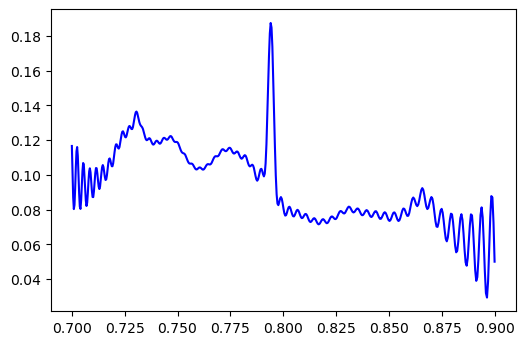

[[0.79406416]]


In [187]:
# Get cavity mode
ldos_results = np.transpose(
                    np.array([mp.get_ldos_freqs(ldos_instance), sim.ldos_data]))

plt.figure(dpi=100)
plt.plot(1 / ldos_results[:, 0], ldos_results[:, 1], 'b-')
plt.show()
maximum = max(ldos_results[:, 1])
index = np.where(ldos_results[:, 1] == maximum)
mode_wvl=1/ldos_results[index, 0]
print(mode_wvl)

Text(0, 0.5, 'Arbitrary intensity')

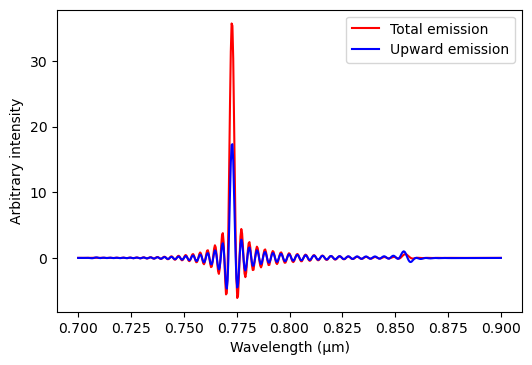

In [186]:
flux_freqs = np.array(mp.get_flux_freqs(box_z2))
flux_up = np.array(mp.get_fluxes(box_z2))
flux_bot = np.array(mp.get_fluxes(box_z1))
flux_side = np.array(mp.get_fluxes(box_r))
flux_total= -flux_bot+flux_up-flux_side
flux_upwards= np.array(mp.get_fluxes(box_up))

flux_wvl=1/flux_freqs
plt.figure(dpi=100)
plt.plot(flux_wvl, flux_total, 'r-', label='Total emission')

plt.plot(flux_wvl, flux_upwards, 'b-',label='Upward emission')
plt.legend(loc='upper right')
plt.xlabel('Wavelength (µm)')
plt.ylabel('Arbitrary intensity')


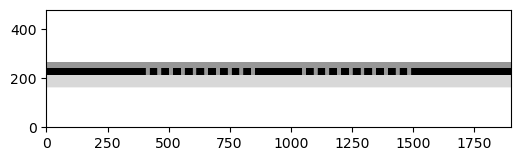

In [268]:
# Draw X-Z plane of structure (Au not visible)

eps_data_Y=sim.get_array(center=mp.Vector3(0,0,ddev/2+0.01), size=mp.Vector3(sr,0,4),
                                                  component=mp.Dielectric)
plt.figure(dpi=100)
plt.imshow(eps_data_Y, interpolation='none', origin='lower', cmap="Greys")
plt.show()


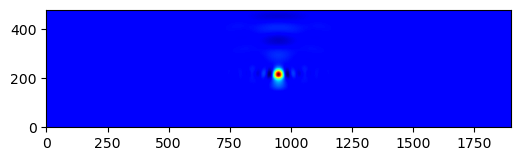

In [254]:
er_data_list=[]
er_data_list.append(sim.get_array(center=mp.Vector3(0,0,ddev/2+0.1),
                                                               size=mp.Vector3(sr, 0, 4),
                                                               component=mp.Er).real)
er_data = np.array(er_data_list)

for i in range(len(er_data)):
    plt.figure(i, dpi=100)
    #plt.imshow(eps_data_Y, interpolation='none', origin='lower', cmap="Greys")
    plt_data = er_data[i]
    plt.imshow(plt_data, interpolation='none', origin='lower', cmap = plt.cm.jet)


plt.show()

In [267]:
# Get Q factors
first_mode = harminv_instance.modes[0]
second_mode  = harminv_instance.modes[1]
third_mode  = harminv_instance.modes[2]

q_results = []
for mode in harminv_instance.modes:
    q_results.append([1000/mode.freq, mode.decay, mode.Q, abs(mode.amp)])

q_results = np.array(q_results)
print("Wavelength in nm:", q_results[0,0])
print("Decay:", q_results[0,1])
print("Q factor:", q_results[0,2])
print("Amplitude:", q_results[0,3])




Wavelength in nm: 794.3152570182416
Decay: -0.001815937560741966
Q factor: 346.638014330676
Amplitude: 0.003556546556050493
